In [19]:
#Import MNIST dataset with torchvision

import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
#import torchvision.transforms as transforms

from typing import Type
import tqdm 

In [29]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = 0.1307, std = 0.3081)
])

In [30]:
mnist_trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
mnist_testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

In [22]:
print(mnist_testset[0][0])

<PIL.Image.Image image mode=L size=28x28 at 0x11138E0D0>


In [23]:
mean = mnist_trainset.data.float().mean()/255
std = mnist_trainset.data.float().std()/255
print('mean:', mean)
print('std:', std)

mean: tensor(0.1307)
std: tensor(0.3081)


In [31]:
class MNIST_classifier(nn.Module):
    def __init__(self):
        super(MNIST_classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride = 2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride = 2, padding=1)
        #self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride = 3)
        
        self.conv_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(576, 10)

        self.fc2 = nn.Linear(256, 10)

        

        self.max_pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.max_pool(F.relu(self.conv2(x))))
        x = self.conv_drop(x)
        #print(x.shape)
        x = x.view(-1, 576)
    
        #print(x.shape)
        x = self.fc1(x)
        #x = F.dropout(x, training=self.training)
        #x = F.relu(x)
        return x
    

    #FOR MAC 
device = torch.device('mps')

model = MNIST_classifier().to(device)

train_loader = DataLoader(mnist_trainset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=64, shuffle=True)

In [11]:
def train(model, train_loader, optimizer, epoch, critetion, acc_dict, loss_dict) :
    model.train()
    total_loss = 0 
    total_acc = 0
    with tqdm.tqdm(range(len(train_loader))) as pbar:
        
        for X,Y in train_loader:
            X,Y = X.to(device), Y.to(device)

            optimizer.zero_grad()
            output = model(X).to(device)
            #print(output.shape, Y.shape)
            loss = critetion(output, Y)
            pred = output.argmax(dim=1, keepdim=True)
            correct = pred.eq(Y.view_as(pred)).sum().item()
            total_loss += loss.item()
            total_acc += correct/len(X)
            loss.backward()

            optimizer.step()    
            pbar.update(1)
    
    acc_dict[epoch] = [total_acc/len(train_loader)*100]
    loss_dict[epoch] = [total_loss/len(train_loader)]
    print(f'[TRAIN] : For epoch {epoch}, the loss is {total_loss/len(train_loader)} and the accuracy is {total_acc/len(train_loader)*100}')

In [12]:
def test(model, test_loader , epoch, criterion, best_loss, acc_dict, loss_dict):
    model.eval()
    with torch.no_grad():
        total_acc = 0 
        total_loss = 0 
        with tqdm.tqdm(range(len(test_loader))) as pbar:
            for X,Y in test_loader : 
                X,Y = X.to(device), Y.to(device)
                output = model(X).to(device)

                loss = criterion(output, Y)
                pred = output.argmax(dim=1, keepdim=True)
                correct = pred.eq(Y.view_as(pred)).sum().item()
                total_acc += correct/len(X)
                total_loss += loss.item()
                pbar.update(1)

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    torch.save(model.state_dict(), 'model/best_model.pth')

        acc_dict[epoch].append(total_acc/len(test_loader)*100)
        loss_dict[epoch].append(total_loss/len(test_loader))
        print(f'[TEST] : For epoch {epoch}, the loss is {total_loss/len(test_loader)} and the accuracy is {total_acc/len(test_loader)*100}')

        return best_loss


In [333]:
acc_dict = {}
loss_dict = {}
criterion = F.cross_entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)#.to(device)
epochs = 20
best_loss = 1000
for epoch in range(epochs) : 
    train(model, train_loader, optimizer, epoch, criterion, acc_dict, loss_dict)
    best_loss = test(model, test_loader, epoch, criterion, best_loss, acc_dict, loss_dict)

100%|██████████| 938/938 [00:07<00:00, 120.82it/s]


[TRAIN] : For epoch 0, the loss is 0.02724868702784261 and the accuracy is 99.07216151385929


100%|██████████| 157/157 [00:00<00:00, 201.39it/s]


[TEST] : For epoch 0, the loss is 0.037514647665004626 and the accuracy is 98.90525477707006


100%|██████████| 938/938 [00:07<00:00, 130.40it/s]


[TRAIN] : For epoch 1, the loss is 0.025377319269152834 and the accuracy is 99.15211886993603


100%|██████████| 157/157 [00:00<00:00, 207.82it/s]


[TEST] : For epoch 1, the loss is 0.03693165958781957 and the accuracy is 98.94506369426752


100%|██████████| 938/938 [00:07<00:00, 127.13it/s]


[TRAIN] : For epoch 2, the loss is 0.02396919994852317 and the accuracy is 99.20042643923242


100%|██████████| 157/157 [00:00<00:00, 218.84it/s]


[TEST] : For epoch 2, the loss is 0.03676674895759325 and the accuracy is 98.85549363057325


100%|██████████| 938/938 [00:07<00:00, 132.31it/s]


[TRAIN] : For epoch 3, the loss is 0.02587098904029705 and the accuracy is 99.10547707889125


100%|██████████| 157/157 [00:00<00:00, 211.08it/s]


[TEST] : For epoch 3, the loss is 0.03450338341084207 and the accuracy is 98.90525477707006


100%|██████████| 938/938 [00:07<00:00, 125.30it/s]


[TRAIN] : For epoch 4, the loss is 0.02414475071921211 and the accuracy is 99.17710554371001


100%|██████████| 157/157 [00:00<00:00, 211.54it/s]


[TEST] : For epoch 4, the loss is 0.035017175889766036 and the accuracy is 98.87539808917197


100%|██████████| 938/938 [00:07<00:00, 123.76it/s]


[TRAIN] : For epoch 5, the loss is 0.022974743116114728 and the accuracy is 99.18710021321961


100%|██████████| 157/157 [00:00<00:00, 212.06it/s]


[TEST] : For epoch 5, the loss is 0.037192344964977024 and the accuracy is 98.84554140127389


100%|██████████| 938/938 [00:07<00:00, 123.69it/s]


[TRAIN] : For epoch 6, the loss is 0.02336751930991812 and the accuracy is 99.2087553304904


100%|██████████| 157/157 [00:00<00:00, 205.03it/s]


[TEST] : For epoch 6, the loss is 0.03544528990923531 and the accuracy is 98.90525477707006


100%|██████████| 938/938 [00:07<00:00, 126.22it/s]


[TRAIN] : For epoch 7, the loss is 0.02108141173446203 and the accuracy is 99.27205490405117


100%|██████████| 157/157 [00:00<00:00, 208.02it/s]


[TEST] : For epoch 7, the loss is 0.03705106322263708 and the accuracy is 98.90525477707006


100%|██████████| 938/938 [00:07<00:00, 124.89it/s]


[TRAIN] : For epoch 8, the loss is 0.022673264292254573 and the accuracy is 99.24706823027718


100%|██████████| 157/157 [00:00<00:00, 212.39it/s]


[TEST] : For epoch 8, the loss is 0.037207123035667714 and the accuracy is 99.03463375796179


100%|██████████| 938/938 [00:07<00:00, 131.39it/s]


[TRAIN] : For epoch 9, the loss is 0.02127855938095712 and the accuracy is 99.28038379530916


100%|██████████| 157/157 [00:00<00:00, 220.23it/s]


[TEST] : For epoch 9, the loss is 0.036115275586189745 and the accuracy is 98.98487261146497


100%|██████████| 938/938 [00:07<00:00, 133.83it/s]


[TRAIN] : For epoch 10, the loss is 0.0202443654949376 and the accuracy is 99.32535980810235


100%|██████████| 157/157 [00:00<00:00, 218.49it/s]


[TEST] : For epoch 10, the loss is 0.03923436494494653 and the accuracy is 98.88535031847134


100%|██████████| 938/938 [00:07<00:00, 131.59it/s]


[TRAIN] : For epoch 11, the loss is 0.020451047637830684 and the accuracy is 99.30037313432835


100%|██████████| 157/157 [00:00<00:00, 216.94it/s]


[TEST] : For epoch 11, the loss is 0.03648648977920689 and the accuracy is 98.98487261146497


100%|██████████| 938/938 [00:07<00:00, 130.19it/s]


[TRAIN] : For epoch 12, the loss is 0.018887205338145585 and the accuracy is 99.33702025586354


100%|██████████| 157/157 [00:00<00:00, 211.03it/s]


[TEST] : For epoch 12, the loss is 0.03468864805294126 and the accuracy is 99.0047770700637


100%|██████████| 938/938 [00:07<00:00, 126.11it/s]


[TRAIN] : For epoch 13, the loss is 0.020609088079159413 and the accuracy is 99.31369936034116


100%|██████████| 157/157 [00:00<00:00, 209.22it/s]


[TEST] : For epoch 13, the loss is 0.03618083814243891 and the accuracy is 98.96496815286623


100%|██████████| 938/938 [00:07<00:00, 124.09it/s]


[TRAIN] : For epoch 14, the loss is 0.02032737906854208 and the accuracy is 99.29704157782517


100%|██████████| 157/157 [00:00<00:00, 212.46it/s]


[TEST] : For epoch 14, the loss is 0.03137391343346564 and the accuracy is 99.02468152866241


100%|██████████| 938/938 [00:07<00:00, 129.38it/s]


[TRAIN] : For epoch 15, the loss is 0.017947652784736853 and the accuracy is 99.36200692963753


100%|██████████| 157/157 [00:00<00:00, 212.61it/s]


[TEST] : For epoch 15, the loss is 0.032453814742375416 and the accuracy is 99.07444267515923


100%|██████████| 938/938 [00:07<00:00, 127.20it/s]


[TRAIN] : For epoch 16, the loss is 0.017239264549771528 and the accuracy is 99.38699360341151


100%|██████████| 157/157 [00:00<00:00, 215.10it/s]


[TEST] : For epoch 16, the loss is 0.043578098424601704 and the accuracy is 98.8156847133758


100%|██████████| 938/938 [00:07<00:00, 126.90it/s]


[TRAIN] : For epoch 17, the loss is 0.018445622990160455 and the accuracy is 99.37533315565032


100%|██████████| 157/157 [00:00<00:00, 217.05it/s]


[TEST] : For epoch 17, the loss is 0.03410566385135064 and the accuracy is 99.02468152866241


100%|██████████| 938/938 [00:07<00:00, 126.35it/s]


[TRAIN] : For epoch 18, the loss is 0.01818762477997651 and the accuracy is 99.38366204690831


100%|██████████| 157/157 [00:00<00:00, 208.89it/s]


[TEST] : For epoch 18, the loss is 0.03569125482164825 and the accuracy is 98.96496815286623


100%|██████████| 938/938 [00:07<00:00, 123.56it/s]


[TRAIN] : For epoch 19, the loss is 0.01653465402595331 and the accuracy is 99.38366204690831


100%|██████████| 157/157 [00:00<00:00, 209.56it/s]

[TEST] : For epoch 19, the loss is 0.03845132978843539 and the accuracy is 98.9749203821656


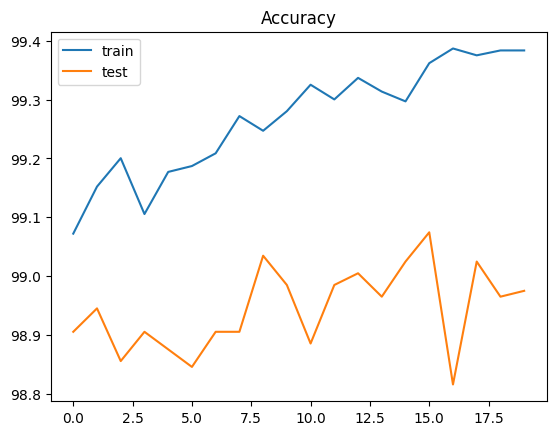

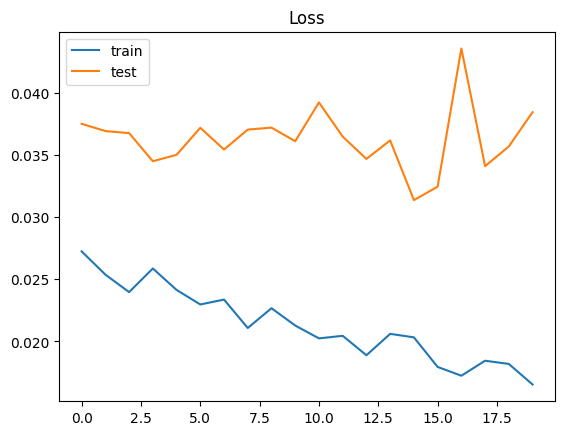

In [335]:
#Plot curves for train and test loss and accuracy train and test
import matplotlib.pyplot as plt

plt.plot(list(acc_dict.keys()), [acc_dict[i][0] for i in acc_dict.keys()], label='train')
plt.plot(list(acc_dict.keys()), [acc_dict[i][1] for i in acc_dict.keys()], label='test')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(list(loss_dict.keys()), [loss_dict[i][0] for i in loss_dict.keys()], label='train')
plt.plot(list(loss_dict.keys()), [loss_dict[i][1] for i in loss_dict.keys()], label='test')
plt.title('Loss')
plt.legend()
plt.show()



# With Resnet18

In [24]:
class ResidualBlock(nn.Module):
    def __init__(self, 
                 in_channels : int, 
                 out_channels : int, 
                 stride : int = 1, 
                   ) -> None:
        super(ResidualBlock, self).__init__()
        
          
        self.conv1 = nn.Conv2d(
            in_channels, 
            out_channels, 
            kernel_size=3, 
            stride=stride, 
            padding=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(
            out_channels, 
            out_channels, 
            kernel_size=3, 
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        if stride != 1 :
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels, 
                    out_channels, 
                    kernel_size=1, 
                    stride=stride, 
                    bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )
        else :
            self.downsample = nn.Identity()

    def forward(self, x : torch.Tensor) -> torch.Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        identity = self.downsample(identity)
        out += identity
        out = self.relu(out)
        
        return out

In [25]:
class ResNet_18(nn.Module):
    def __init__(self,
                 num_classes : int = 35, 
                 ResidualBlock : Type[nn.Module] = ResidualBlock
                 ) -> None :
        super(ResNet_18, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False
        )
        self.num_classes = num_classes

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(
            kernel_size=3,
            stride=2,
            padding=1
        )

        # Residual layers
        self.layer1 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,),
            ResidualBlock(
                in_channels = 64, 
                out_channels = 64,
                stride = 1,)
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(
                in_channels = 64, 
                out_channels = 128,
                stride = 2, ),
            ResidualBlock(
                in_channels = 128, 
                out_channels = 128,
                stride = 1,)
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(
                in_channels = 128, 
                out_channels = 256,
                stride = 2, ),
            ResidualBlock(
                in_channels = 256, 
                out_channels = 256,
                stride = 1,)
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(
                in_channels = 256, 
                out_channels = 512,
                stride = 2, ),
            ResidualBlock(
                in_channels = 512, 
                out_channels = 512,
                stride = 1,)
        )

        self.adaptative_pool = nn.AdaptiveAvgPool2d((1,1))

        self.classify1 = nn.Linear(512, 256)
        self.classify2 = nn.Linear(256, self.num_classes)

    def forward(self, x : torch.Tensor()) -> torch.Tensor :
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        #for classification 
        x = self.adaptative_pool(x)
        x = torch.flatten(x, 1)
        x = self.classify1(x)
        x = self.classify2(x)
        return x

In [32]:

model = ResNet_18().to(device)
acc_dict = {}
loss_dict = {}
criterion = F.cross_entropy
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)#.to(device)
epochs = 20
best_loss = 1000
for epoch in range(epochs) : 
    train(model, train_loader, optimizer, epoch, criterion, acc_dict, loss_dict)
    best_loss = test(model, test_loader, epoch, criterion, best_loss, acc_dict, loss_dict)

100%|█████████▉| 937/938 [00:39<00:00, 27.79it/s]